# Clustering - Finding Related Posts
## Measuring the relatedness of posts
## Preprocessing – similarity measured as a similar number of common words
### Converting raw text into a bag of words

In [1]:
import os
import sys

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df = 1)

In [3]:
print(vectorizer)

CountVectorizer()


In [4]:
content = ["How to format my hard disk", " Hard disk format problems"]

### Vectorizing using transformation

In [5]:
X = vectorizer.fit_transform(content)
vectorizer.get_feature_names()
[u'disk', u'format', u'hard', u'how', u'my', u'problems', u'to']

['disk', 'format', 'hard', 'how', 'my', 'problems', 'to']

### Fetching the counts individually

In [6]:
print(X.toarray().transpose())

[[1 1]
 [1 1]
 [1 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]


In [7]:
DATA_DIR = os.path.join(os.path.dirname(os.path.realpath('/')), "data")

if not os.path.exists(DATA_DIR):
    print("Data directory not found")
    sys.exit(1)

In [8]:
# Posts are located in the system drive directory 'data'
TOY_DIR = os.path.join(DATA_DIR, "toy")
posts = [open(os.path.join(TOY_DIR, f)).read() for f in os.listdir(TOY_DIR)]

### Notifying the vectorizer about the full dataset

In [9]:
X_train = vectorizer.fit_transform(posts)

In [10]:
num_samples, num_features = X_train.shape

In [11]:
print("#samples: %d, #features: %d" % (num_samples, num_features))

#samples: 5, #features: 25


### The following words that have been tokenized will be counted:

In [12]:
print(vectorizer.get_feature_names())

['about', 'actually', 'capabilities', 'contains', 'data', 'databases', 'images', 'imaging', 'interesting', 'is', 'it', 'learning', 'machine', 'most', 'much', 'not', 'permanently', 'post', 'provide', 'save', 'storage', 'store', 'stuff', 'this', 'toy']


In [13]:
new_post = "imaging databases"

In [14]:
new_post_vec = vectorizer.transform([new_post])

Note: The count vectors returned by the transform method are sparse. That is, each vector does not store one count value for each word, as most of those counts will be zero (the post does not contain the word). Instead, it uses the more memoryefficient implementation coo_matrix (for "COOrdinate"). Our new post, for instance, actually contains only two elements:

In [15]:
print(new_post_vec)

  (0, 5)	1
  (0, 7)	1


In [16]:
# Accessing the full ndarray
print(new_post_vec.toarray())

[[0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [17]:
# Calculating the Euclidean distance between the count vectors of the new post and all the old posts
import scipy as sp

def dist_raw(v1, v2):
    delta = v1 - v2
    return sp.linalg.norm(delta.toarray())

In [18]:
def best_post(X, new_vec, dist_func):
    best_doc = None
    best_dist = float('inf') # infinite value as a starting point
    best_i = None
    for i, post in enumerate(posts):
        if post == new_post:
            continue
        post_vec = X.getrow(i)
        d = dist_func(post_vec, new_vec)
        print("=== Post %i with dist=%.2f: '%s'" % (i, d, post))
        if d < best_dist:
            best_dist = d
            best_i = i
    print("n==> Best post is %i with dist=%.2f" % (best_i, best_dist))

In [19]:
best_post(X_train, new_post_vec, dist_raw)

=== Post 0 with dist=4.00: 'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=1.73: 'Imaging databases provide storage capabilities.'
=== Post 2 with dist=2.00: 'Most imaging databases save images permanently.
'
=== Post 3 with dist=1.41: 'Imaging databases store data.'
=== Post 4 with dist=5.10: 'Imaging databases store data. Imaging databases store data. Imaging databases store data.'
n==> Best post is 3 with dist=1.41


In [20]:
print(X_train.getrow(3).toarray())

[[0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]]


In [21]:
print(X_train.getrow(4).toarray())

[[0 0 0 0 3 3 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0]]


We have to normalize them to get vectors of unit length. For this, we have to extend dist_raw to calculate the vector distance not on the raw vectors but on the normalized instead:

In [22]:
def dist_norm(v1, v2):
    v1_normalized = v1 / sp.linalg.norm(v1.toarray())
    v2_normalized = v2 / sp.linalg.norm(v2.toarray())

    delta = v1_normalized - v2_normalized

    return sp.linalg.norm(delta.toarray())

In [23]:
best_post(X_train, new_post_vec, dist_norm)

=== Post 0 with dist=1.41: 'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=0.86: 'Imaging databases provide storage capabilities.'
=== Post 2 with dist=0.92: 'Most imaging databases save images permanently.
'
=== Post 3 with dist=0.77: 'Imaging databases store data.'
=== Post 4 with dist=0.77: 'Imaging databases store data. Imaging databases store data. Imaging databases store data.'
n==> Best post is 3 with dist=0.77


### Removing less important words

In [24]:
vect_engl = CountVectorizer(min_df=1, stop_words='english')

In [25]:
sorted(vect_engl.get_stop_words())[0:20]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amoungst']

In [26]:
X_train_engl = vect_engl.fit_transform(posts)
num_samples_engl, num_features_engl = X_train_engl.shape
print("#samples: %d, #features: %d" % (num_samples_engl,  num_features_engl))
print(vect_engl.get_feature_names())

#samples: 5, #features: 18
['actually', 'capabilities', 'contains', 'data', 'databases', 'images', 'imaging', 'interesting', 'learning', 'machine', 'permanently', 'post', 'provide', 'save', 'storage', 'store', 'stuff', 'toy']


In [27]:
new_post_vec_engl = vect_engl.transform([new_post]) 
print(new_post_vec_engl)

  (0, 4)	1
  (0, 6)	1


In [28]:
best_post(X_train_engl, new_post_vec_engl, dist_norm)

=== Post 0 with dist=1.41: 'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=0.86: 'Imaging databases provide storage capabilities.'
=== Post 2 with dist=0.86: 'Most imaging databases save images permanently.
'
=== Post 3 with dist=0.77: 'Imaging databases store data.'
=== Post 4 with dist=0.77: 'Imaging databases store data. Imaging databases store data. Imaging databases store data.'
n==> Best post is 3 with dist=0.77


### Stemming

In [29]:
import nltk.stem

In [30]:
s = nltk.stem.SnowballStemmer('english')

In [31]:
s.stem("graphics")

'graphic'

In [32]:
s.stem("imaging")

'imag'

In [33]:
s.stem("image")

'imag'

In [34]:
s.stem("imagination")

'imagin'

In [35]:
s.stem("imagine")

'imagin'

In [36]:
s.stem("buys")

'buy'

In [37]:
s.stem("buying")

'buy'

In [38]:
s.stem("bought")

'bought'

### Extending the vectorizer with NLTK's stemmer

In [39]:
english_stemmer = nltk.stem.SnowballStemmer('english')

In [40]:
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))

In [41]:
vect_engl_stem = StemmedCountVectorizer(min_df=1, stop_words='english')        

In [42]:
print(vect_engl_stem)

StemmedCountVectorizer(stop_words='english')


In [43]:
X_train_engl_stem = vect_engl_stem.fit_transform(posts)
num_samples_engl_stem, num_features_engl_stem = X_train_engl_stem.shape
print("#samples: %d, #features: %d" % (num_samples_engl_stem,  num_features_engl_stem))
print(vect_engl_stem.get_feature_names())

#samples: 5, #features: 17
['actual', 'capabl', 'contain', 'data', 'databas', 'imag', 'interest', 'learn', 'machin', 'perman', 'post', 'provid', 'save', 'storag', 'store', 'stuff', 'toy']


In [44]:
new_post_vec_engl_stem = vect_engl_stem.transform([new_post]) 
print(new_post_vec_engl_stem)

  (0, 4)	1
  (0, 5)	1


In [45]:
best_post(X_train_engl_stem, new_post_vec_engl_stem, dist_norm)

=== Post 0 with dist=1.41: 'This is a toy post about machine learning. Actually, it contains not much interesting stuff.'
=== Post 1 with dist=0.86: 'Imaging databases provide storage capabilities.'
=== Post 2 with dist=0.63: 'Most imaging databases save images permanently.
'
=== Post 3 with dist=0.77: 'Imaging databases store data.'
=== Post 4 with dist=0.77: 'Imaging databases store data. Imaging databases store data. Imaging databases store data.'
n==> Best post is 2 with dist=0.63


### Stop words on steroids
Term Frequency - Inverse Document Frequency (TF-IDF)

In [46]:
import numpy as np
def tfidf(term, doc, corpus):
    tf = doc.count(term) / len(doc)
    idf = np.log(float(len(corpus)) / (len([d for d in corpus if term in d])))
    tf_idf = tf * idf
    print("term='%s'   doc=%-17s tf=%.2f   idf=%.2f"%\
          (term, doc, tf, idf))
    return tf_idf

In [47]:
# Defining some documents
a, abb, abc = ["a"], ["a", "b", "b"], ["a", "b", "c"]

In [48]:
# Defining some copora
D = [a, abb, abc]

In [49]:
print("=> tfidf=%.2f" % tfidf("a", a, D))

term='a'   doc=['a']             tf=1.00   idf=0.00
=> tfidf=0.00


In [50]:
print("=> tfidf=%.2f" % tfidf("a", abb, D))

term='a'   doc=['a', 'b', 'b']   tf=0.33   idf=0.00
=> tfidf=0.00


In [51]:
print("=> tfidf=%.2f" % tfidf("a", abc, D))

term='a'   doc=['a', 'b', 'c']   tf=0.33   idf=0.00
=> tfidf=0.00


In [52]:
print("=> tfidf=%.2f" % tfidf("b", abb, D))

term='b'   doc=['a', 'b', 'b']   tf=0.67   idf=0.41
=> tfidf=0.27


In [53]:
print("=> tfidf=%.2f" % tfidf("b", abc, D))

term='b'   doc=['a', 'b', 'c']   tf=0.33   idf=0.41
=> tfidf=0.14


In [54]:
print("=> tfidf=%.2f" % tfidf("c", abc, D))

term='c'   doc=['a', 'b', 'c']   tf=0.33   idf=1.10
=> tfidf=0.37


In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [56]:
class StemmedTfidfVectorizer(TfidfVectorizer):

    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        return lambda doc: (english_stemmer.stem(w) for w in analyzer(doc))

In [57]:
vect_tfidf = StemmedTfidfVectorizer(stop_words='english', decode_error='ignore')

In [58]:
print(vect_tfidf)

StemmedTfidfVectorizer(decode_error='ignore', stop_words='english')


In [59]:
X_train_tfidf = vect_tfidf.fit_transform(posts)
num_samples_tfidf, num_features_tfidf = X_train_tfidf.shape
print("#samples: %d, #features: %d" % (num_samples_tfidf,  num_features_tfidf))
print(vect_tfidf.get_feature_names())

#samples: 5, #features: 17
['actual', 'capabl', 'contain', 'data', 'databas', 'imag', 'interest', 'learn', 'machin', 'perman', 'post', 'provid', 'save', 'storag', 'store', 'stuff', 'toy']


The resulting document vectors will not contain counts any more. Instead, they will contain the individual TF-IDF values per term.

In [60]:
new_post_vec_tfidf = vect_tfidf.transform([new_post]) 
print(new_post_vec_tfidf)

  (0, 5)	0.7071067811865476
  (0, 4)	0.7071067811865476


## Clustering
### K-means

In [61]:
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [62]:
seed = 2
sp.random.seed(seed)  # to reproduce the data later on

In [63]:
num_clusters = 3
DPI = 300

<module 'matplotlib.pyplot' from 'c:\\users\\praab\\appdata\\local\\programs\\python\\python38\\lib\\site-packages\\matplotlib\\pyplot.py'>

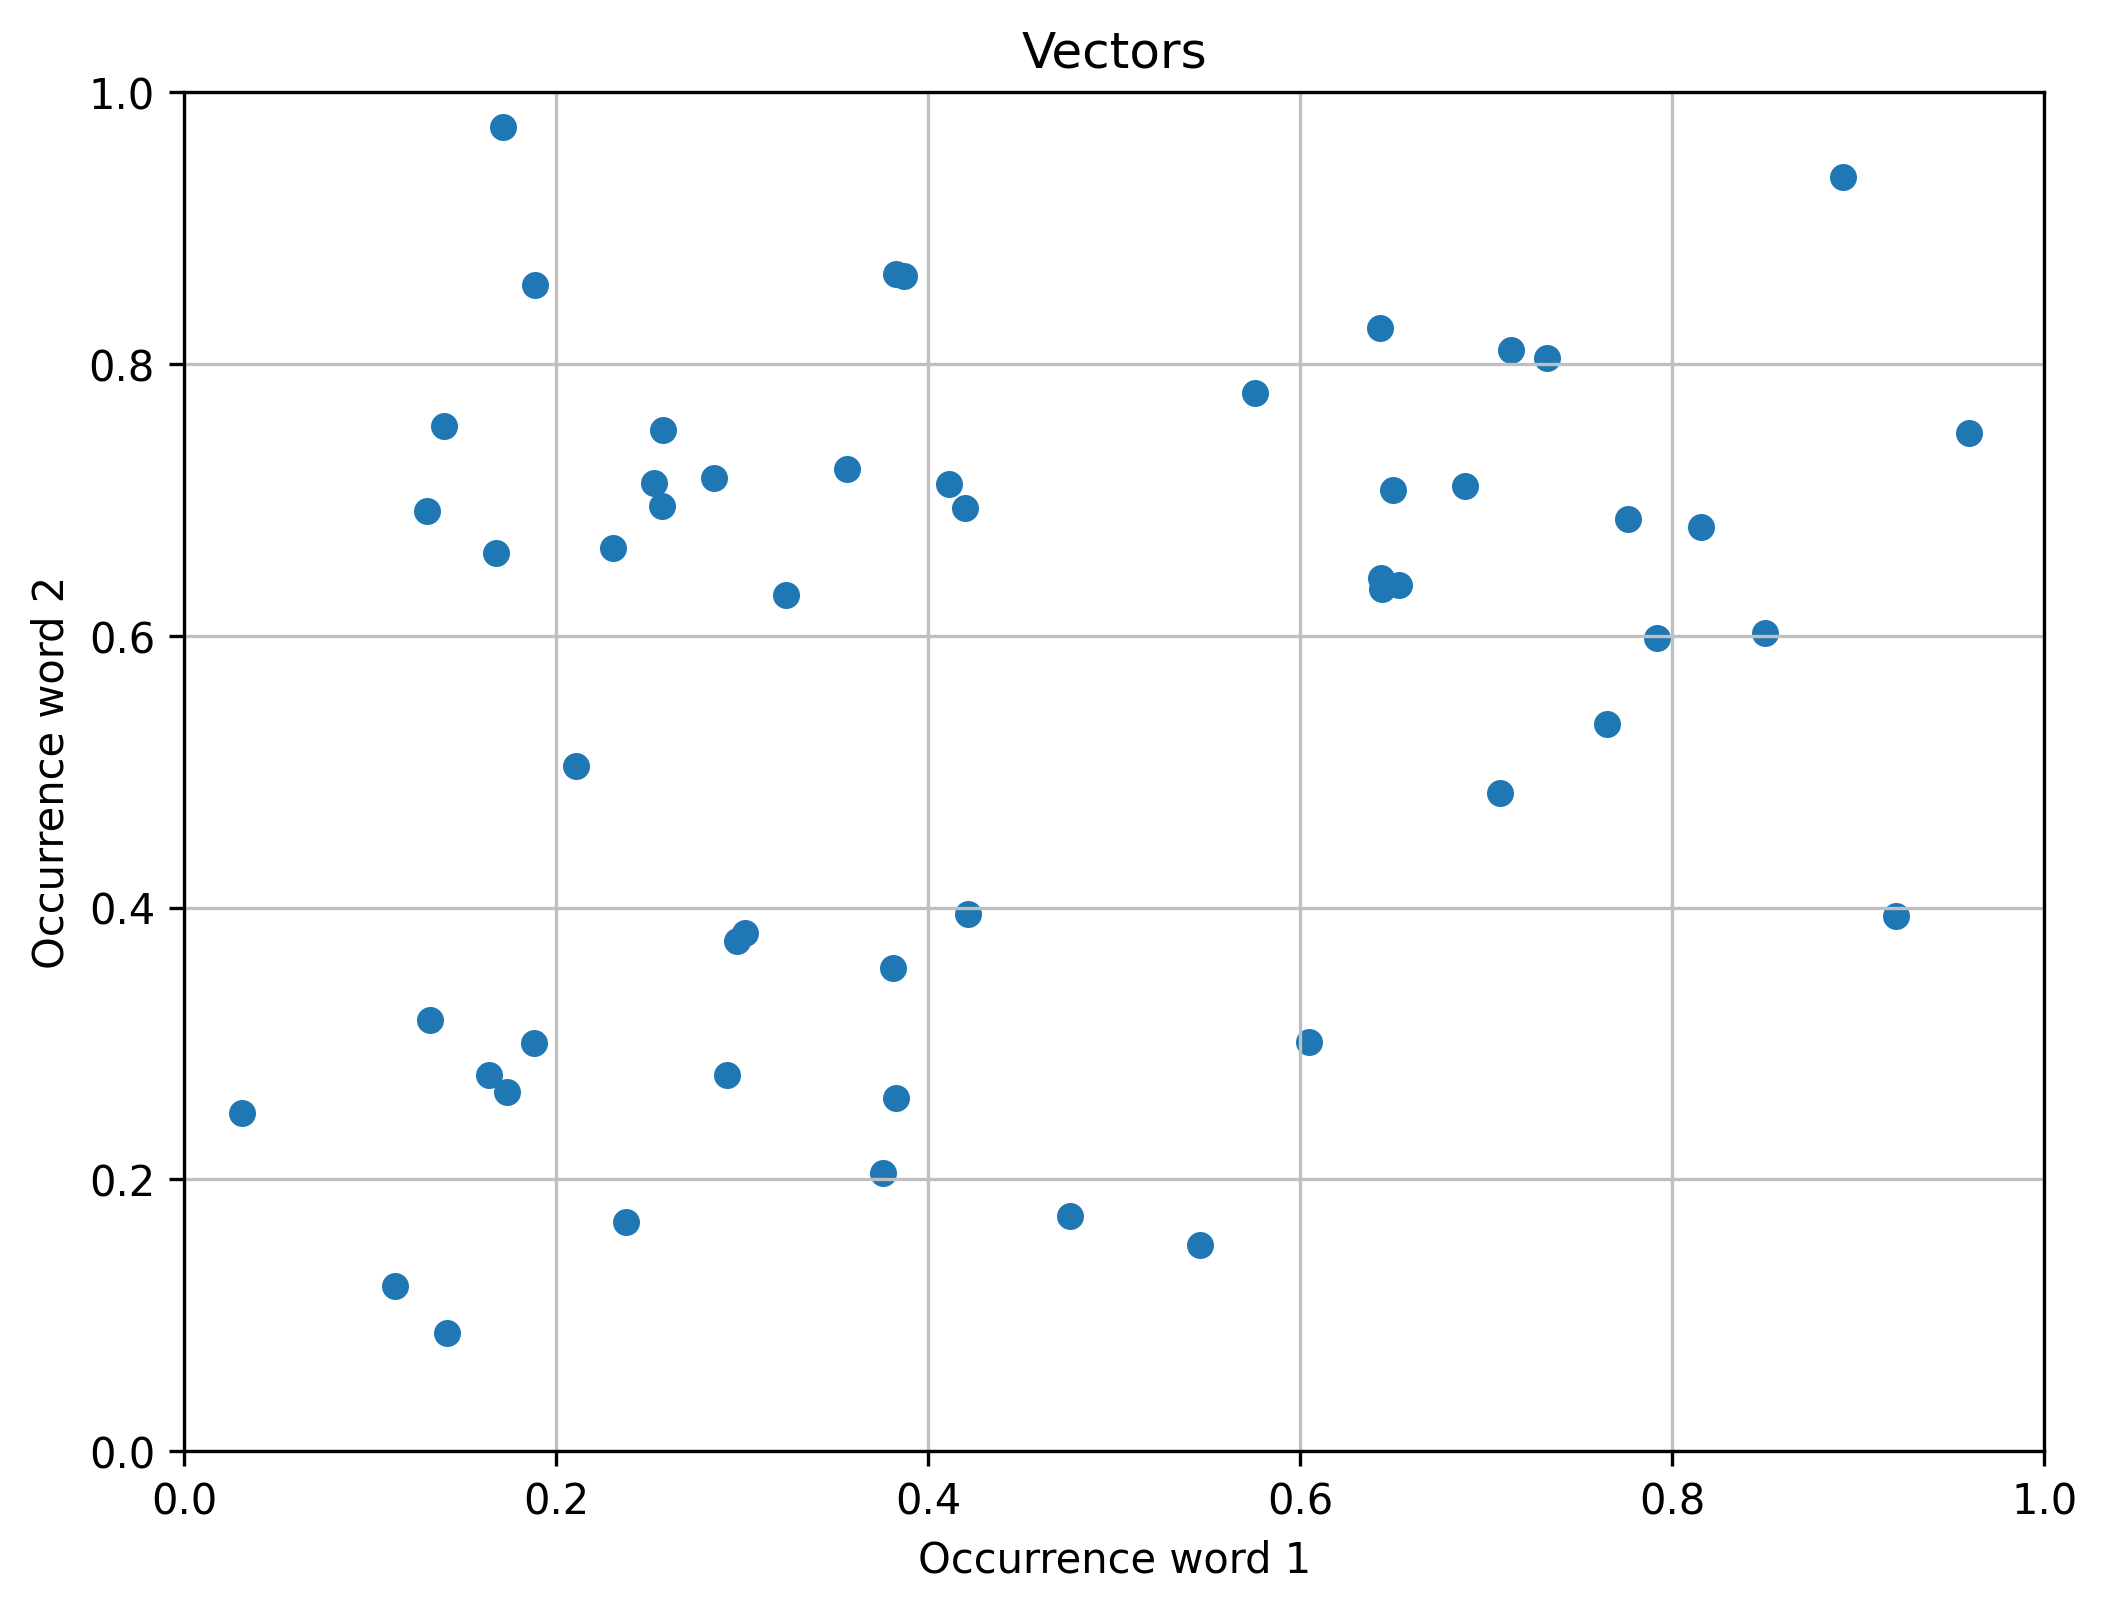

In [64]:
def plot_clustering(x, y, title, mx=None, ymax=None, xmin=None, km=None):
    plt.figure(num=None, figsize=(8, 6), dpi=DPI)
    if km:
        plt.scatter(x, y, s=30, c=km.predict(list(zip(x, y))))
    else:
        plt.scatter(x, y, s=30)

    plt.title(title)
    plt.xlabel("Occurrence word 1")
    plt.ylabel("Occurrence word 2")

    plt.autoscale(tight=True)
    plt.ylim(ymin=0, ymax=1)
    plt.xlim(xmin=0, xmax=1)
    plt.grid(True, linestyle='-', color='0.75')

    return plt


xw1 = sp.stats.norm(loc=0.3, scale=.15).rvs(20)
yw1 = sp.stats.norm(loc=0.3, scale=.15).rvs(20)

xw2 = sp.stats.norm(loc=0.7, scale=.15).rvs(20)
yw2 = sp.stats.norm(loc=0.7, scale=.15).rvs(20)

xw3 = sp.stats.norm(loc=0.2, scale=.15).rvs(20)
yw3 = sp.stats.norm(loc=0.8, scale=.15).rvs(20)

x = np.append(np.append(xw1, xw2), xw3)
y = np.append(np.append(yw1, yw2), yw3)

plot_clustering(x, y, "Vectors")

### Clustering after first iteration

Initialization complete
Iteration 0, inertia 4.7485267474116775


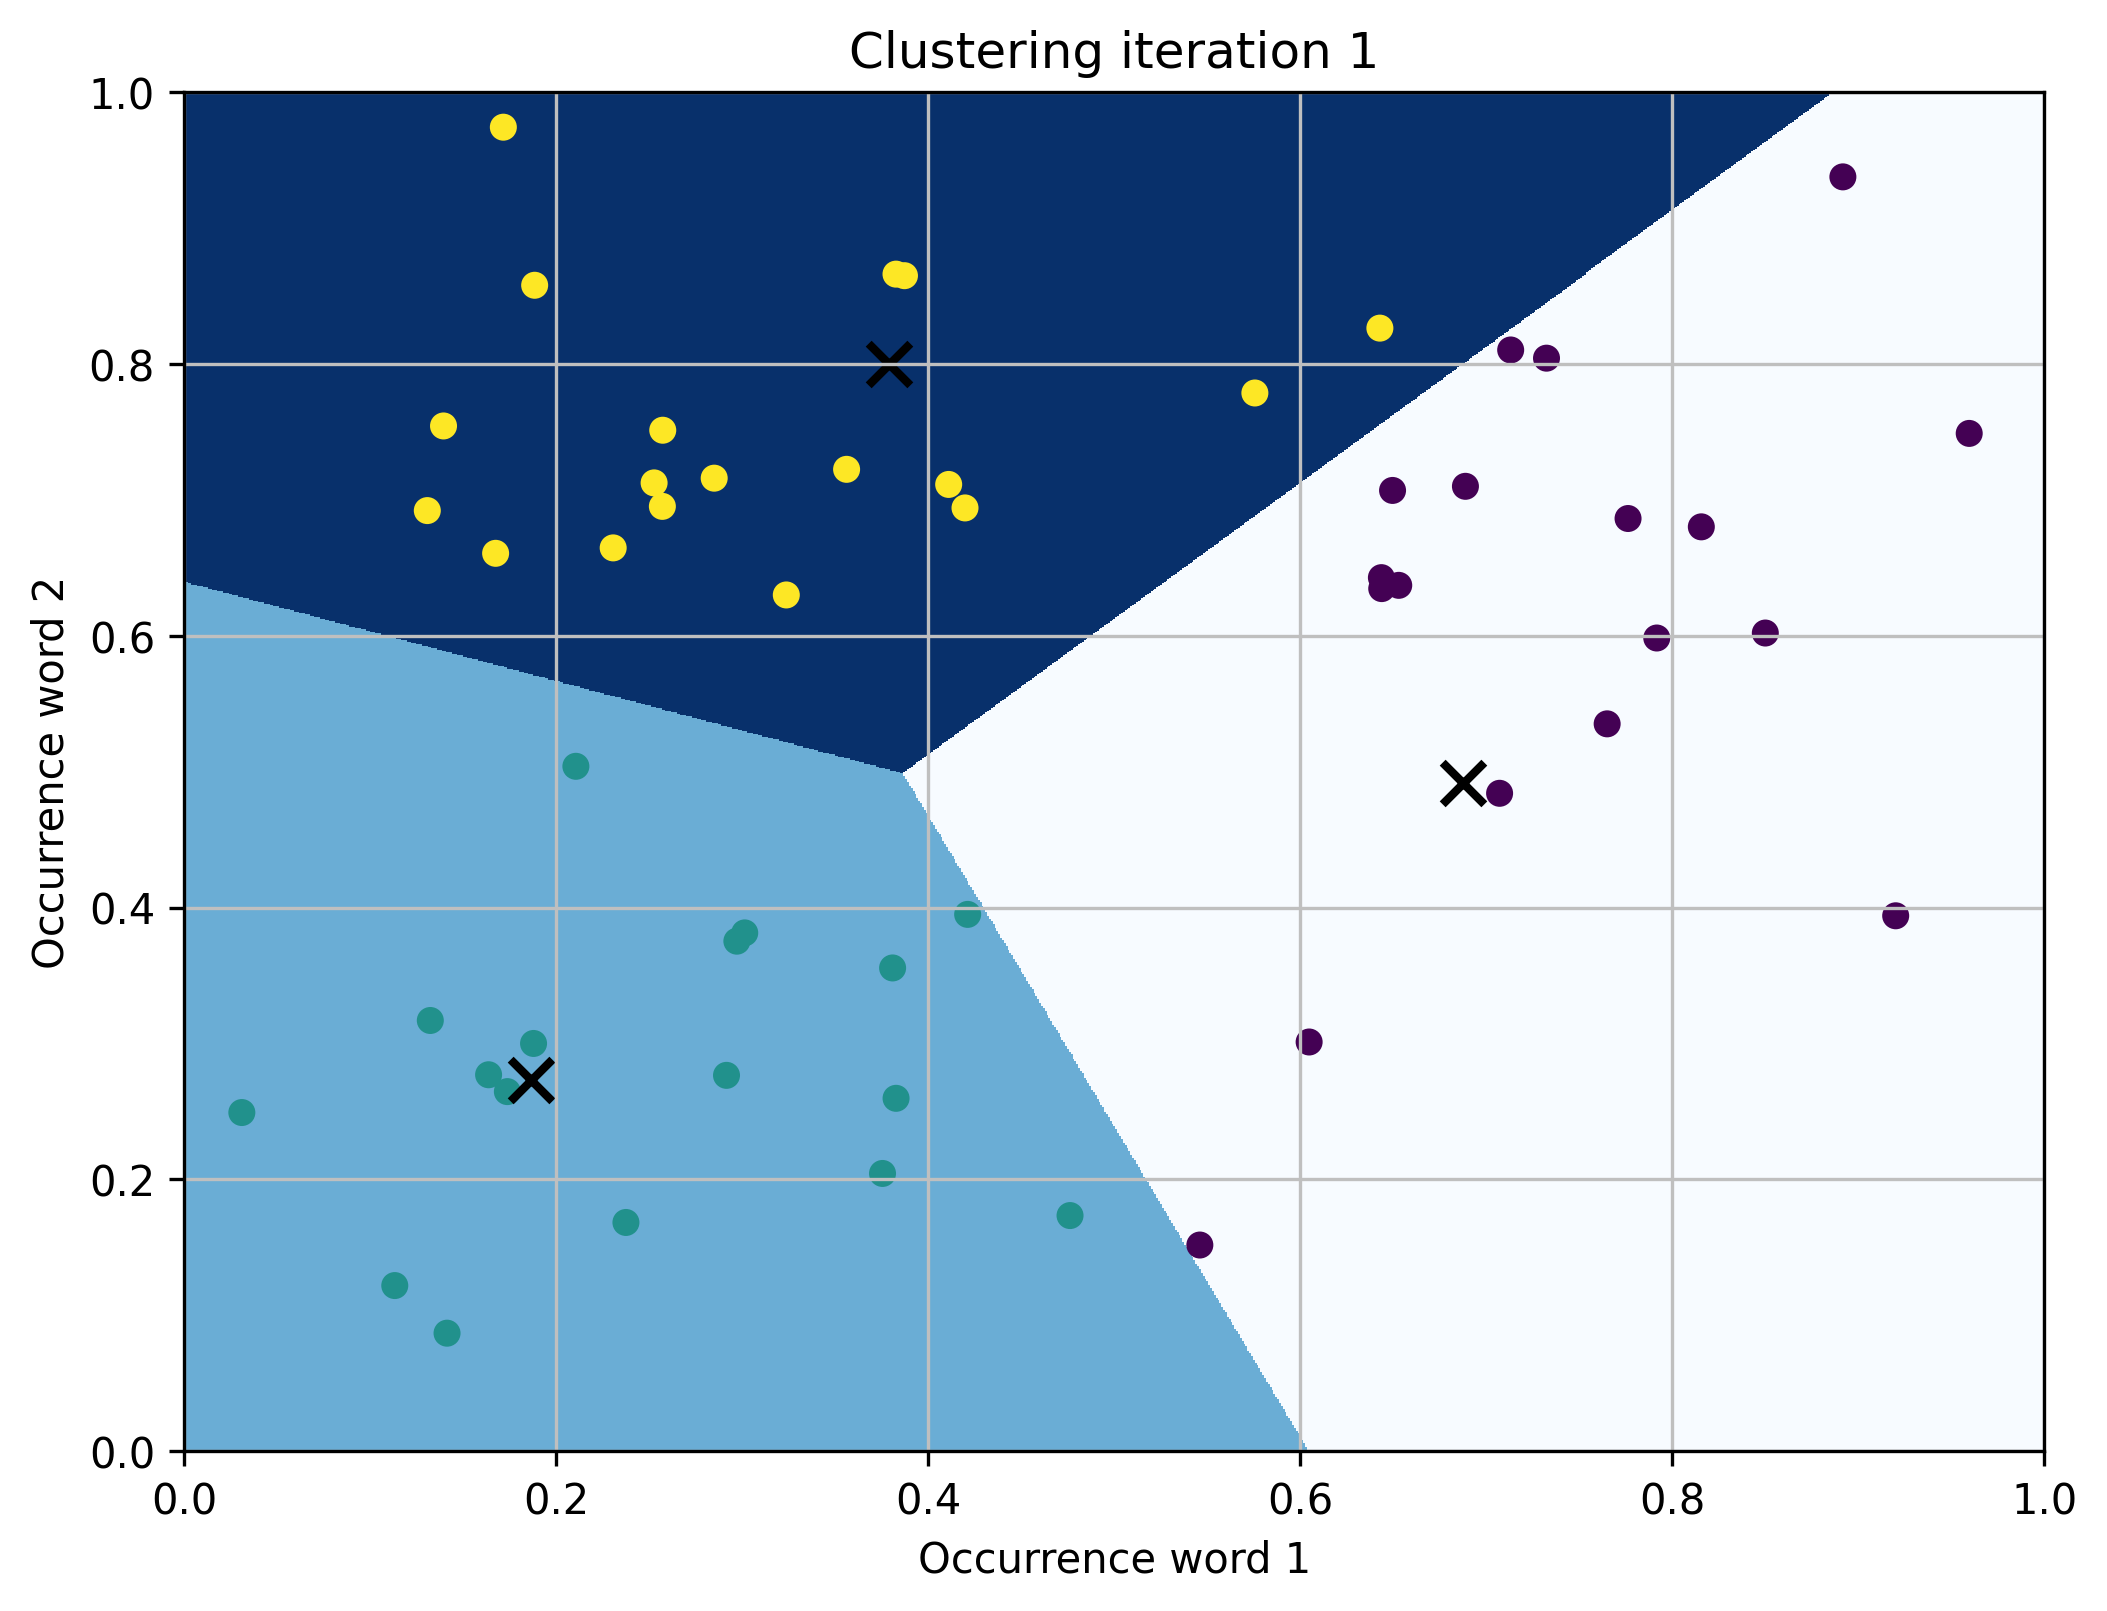

In [65]:
mx, my = np.meshgrid(np.arange(0, 1, 0.001), np.arange(0, 1, 0.001))

km = KMeans(init='random', n_clusters=num_clusters, verbose=1, n_init=1, max_iter=1, random_state=seed)
km.fit(np.array(list(zip(x, y))))

Z = km.predict(np.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 1", km=km)
plt.imshow(Z, interpolation='nearest', extent=(mx.min(), mx.max(), my.min(), my.max()), cmap=plt.cm.Blues, aspect='auto', origin='lower')

c1a, c1b, c1c = km.cluster_centers_
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], marker='x', linewidth=2, s=100, color='black')

### Clustering after second iteration

Initialization complete
Iteration 0, inertia 4.7485267474116775
Iteration 1, inertia 3.3787856939654466


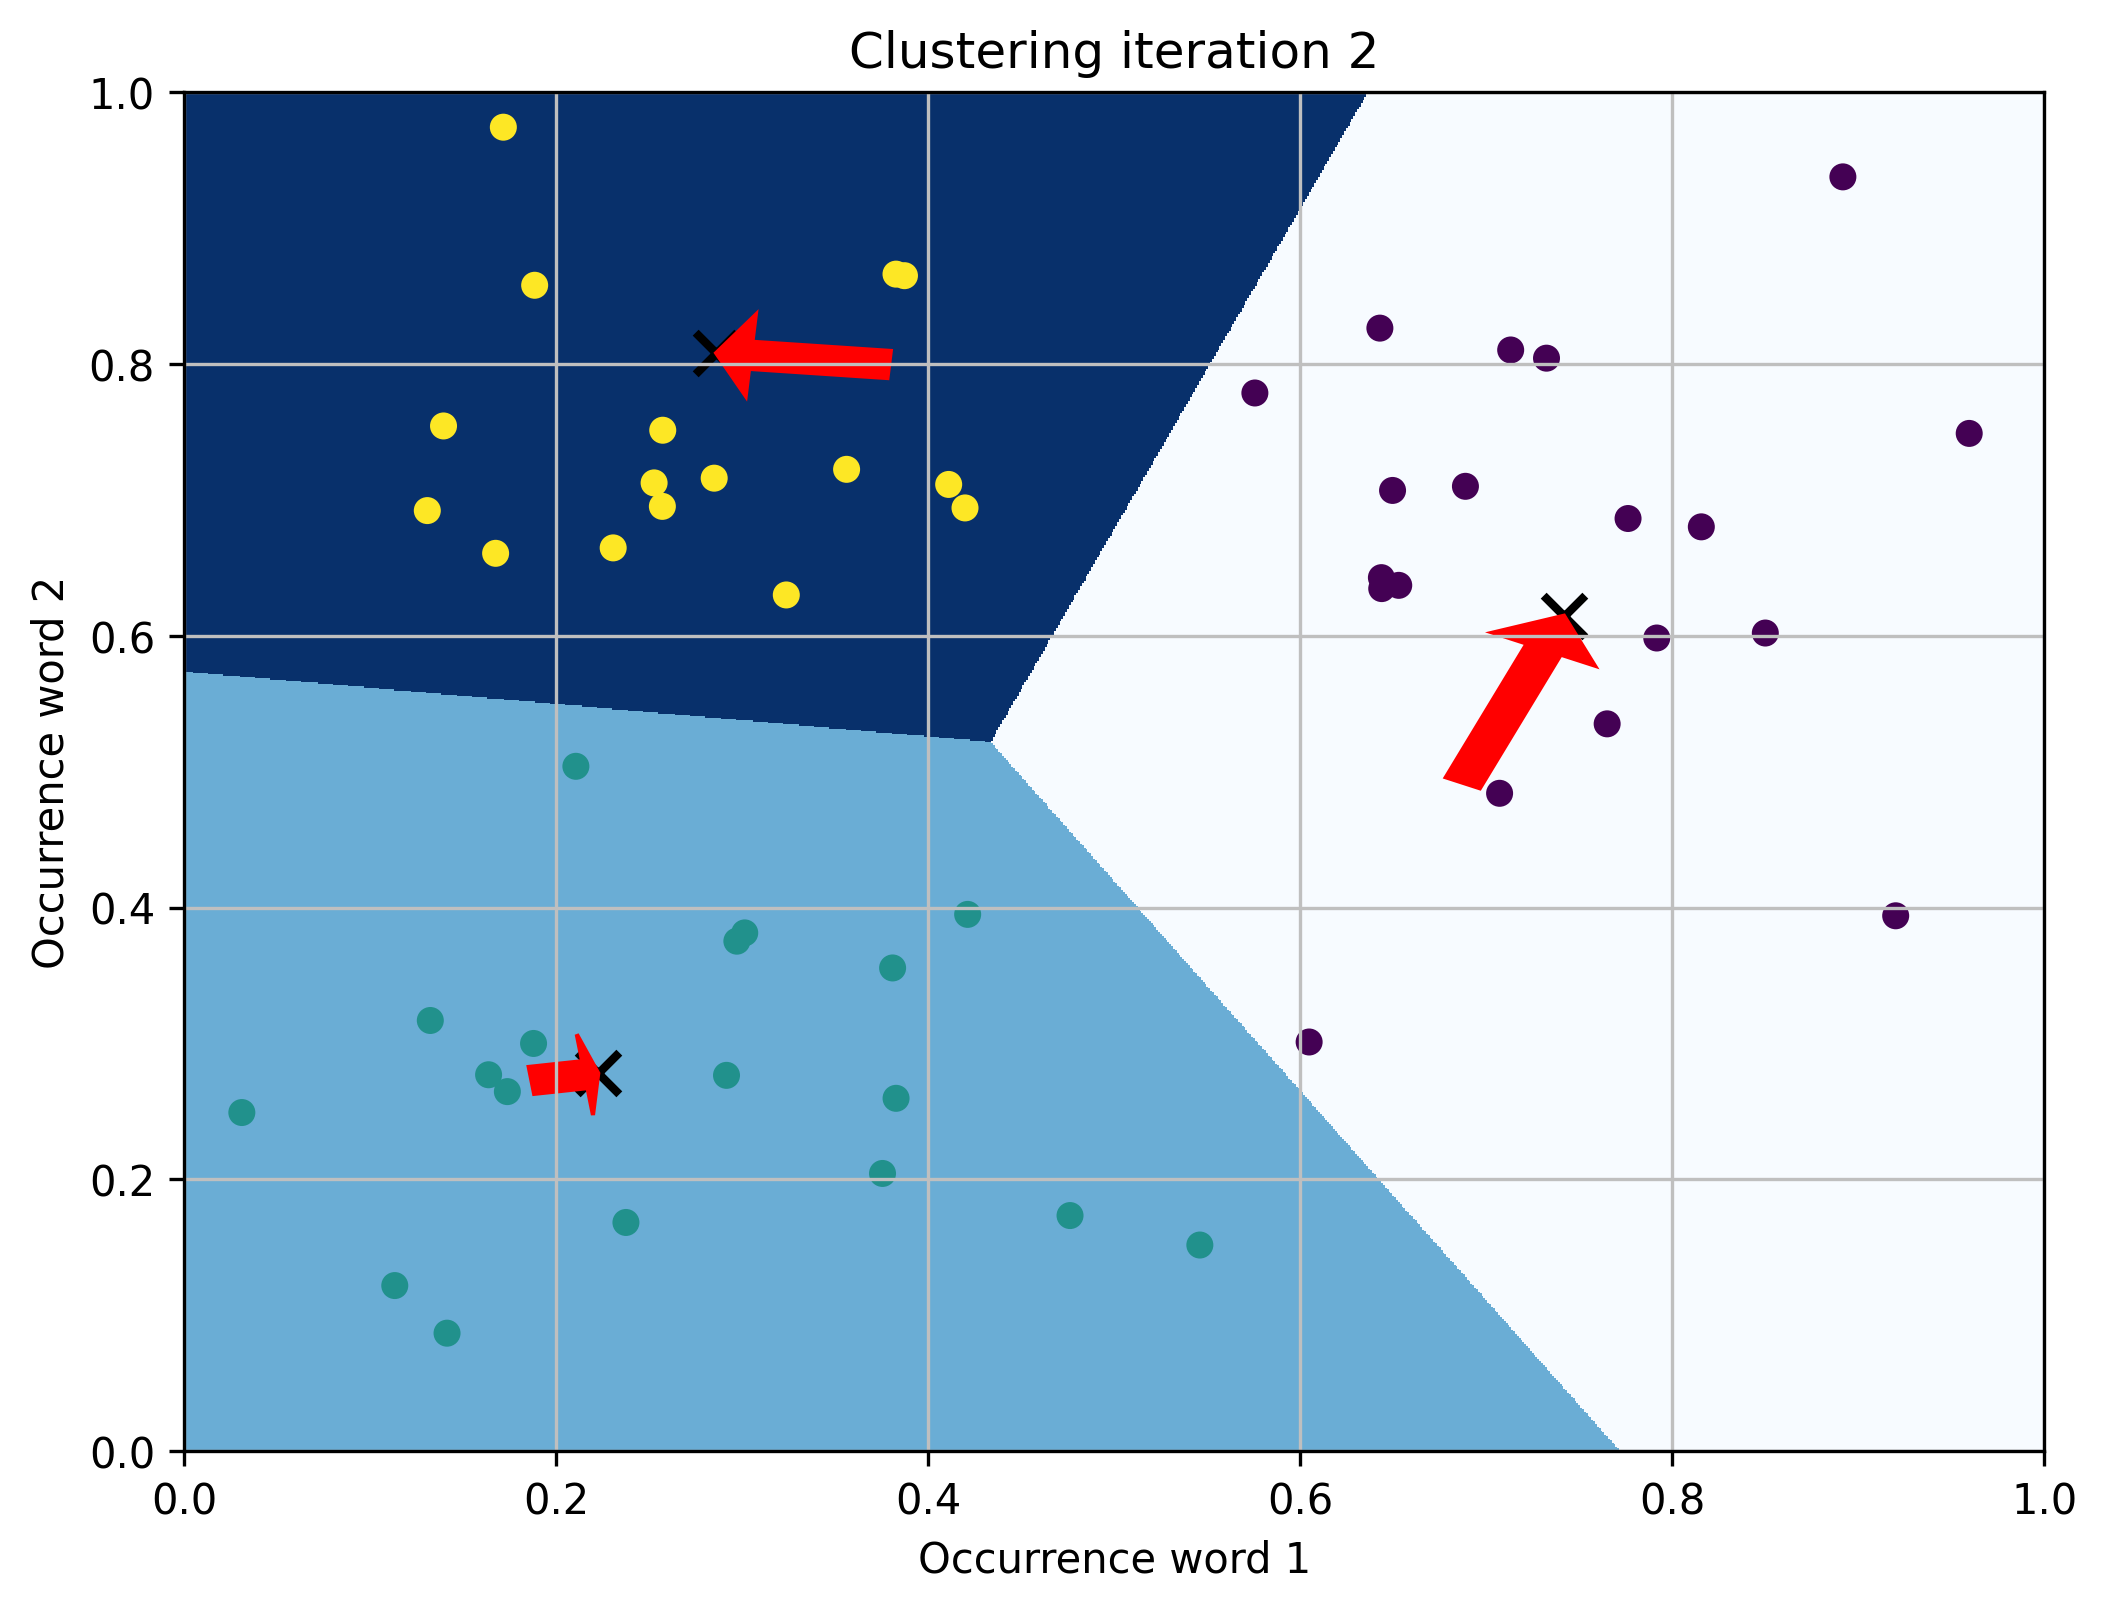

In [66]:
km = KMeans(init='random', n_clusters=num_clusters, verbose=1, n_init=1, max_iter=2, random_state=seed)
km.fit(np.array(list(zip(x, y))))

Z = km.predict(np.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 2", km=km)
plt.imshow(Z, interpolation='nearest', extent=(mx.min(), mx.max(), my.min(), my.max()), cmap=plt.cm.Blues, aspect='auto', origin='lower')

c2a, c2b, c2c = km.cluster_centers_
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], marker='x', linewidth=2, s=100, color='black')

plt.gca().add_patch(plt.Arrow(c1a[0], c1a[1], c2a[0] - c1a[0], c2a[1] - c1a[1], width=0.1, color='red'))
plt.gca().add_patch(plt.Arrow(c1b[0], c1b[1], c2b[0] - c1b[0], c2b[1] - c1b[1], width=0.1, color='red'))
plt.gca().add_patch(plt.Arrow(c1c[0], c1c[1], c2c[0] - c1c[0], c2c[1] - c1c[1], width=0.1, color='red'))

### Final clustering

Initialization complete
Iteration 0, inertia 4.7485267474116775
Iteration 1, inertia 3.3787856939654466
Iteration 2, inertia 2.5999573206286977
Iteration 3, inertia 2.496571140237421
Iteration 4, inertia 2.447223016211801
Converged at iteration 4: strict convergence.


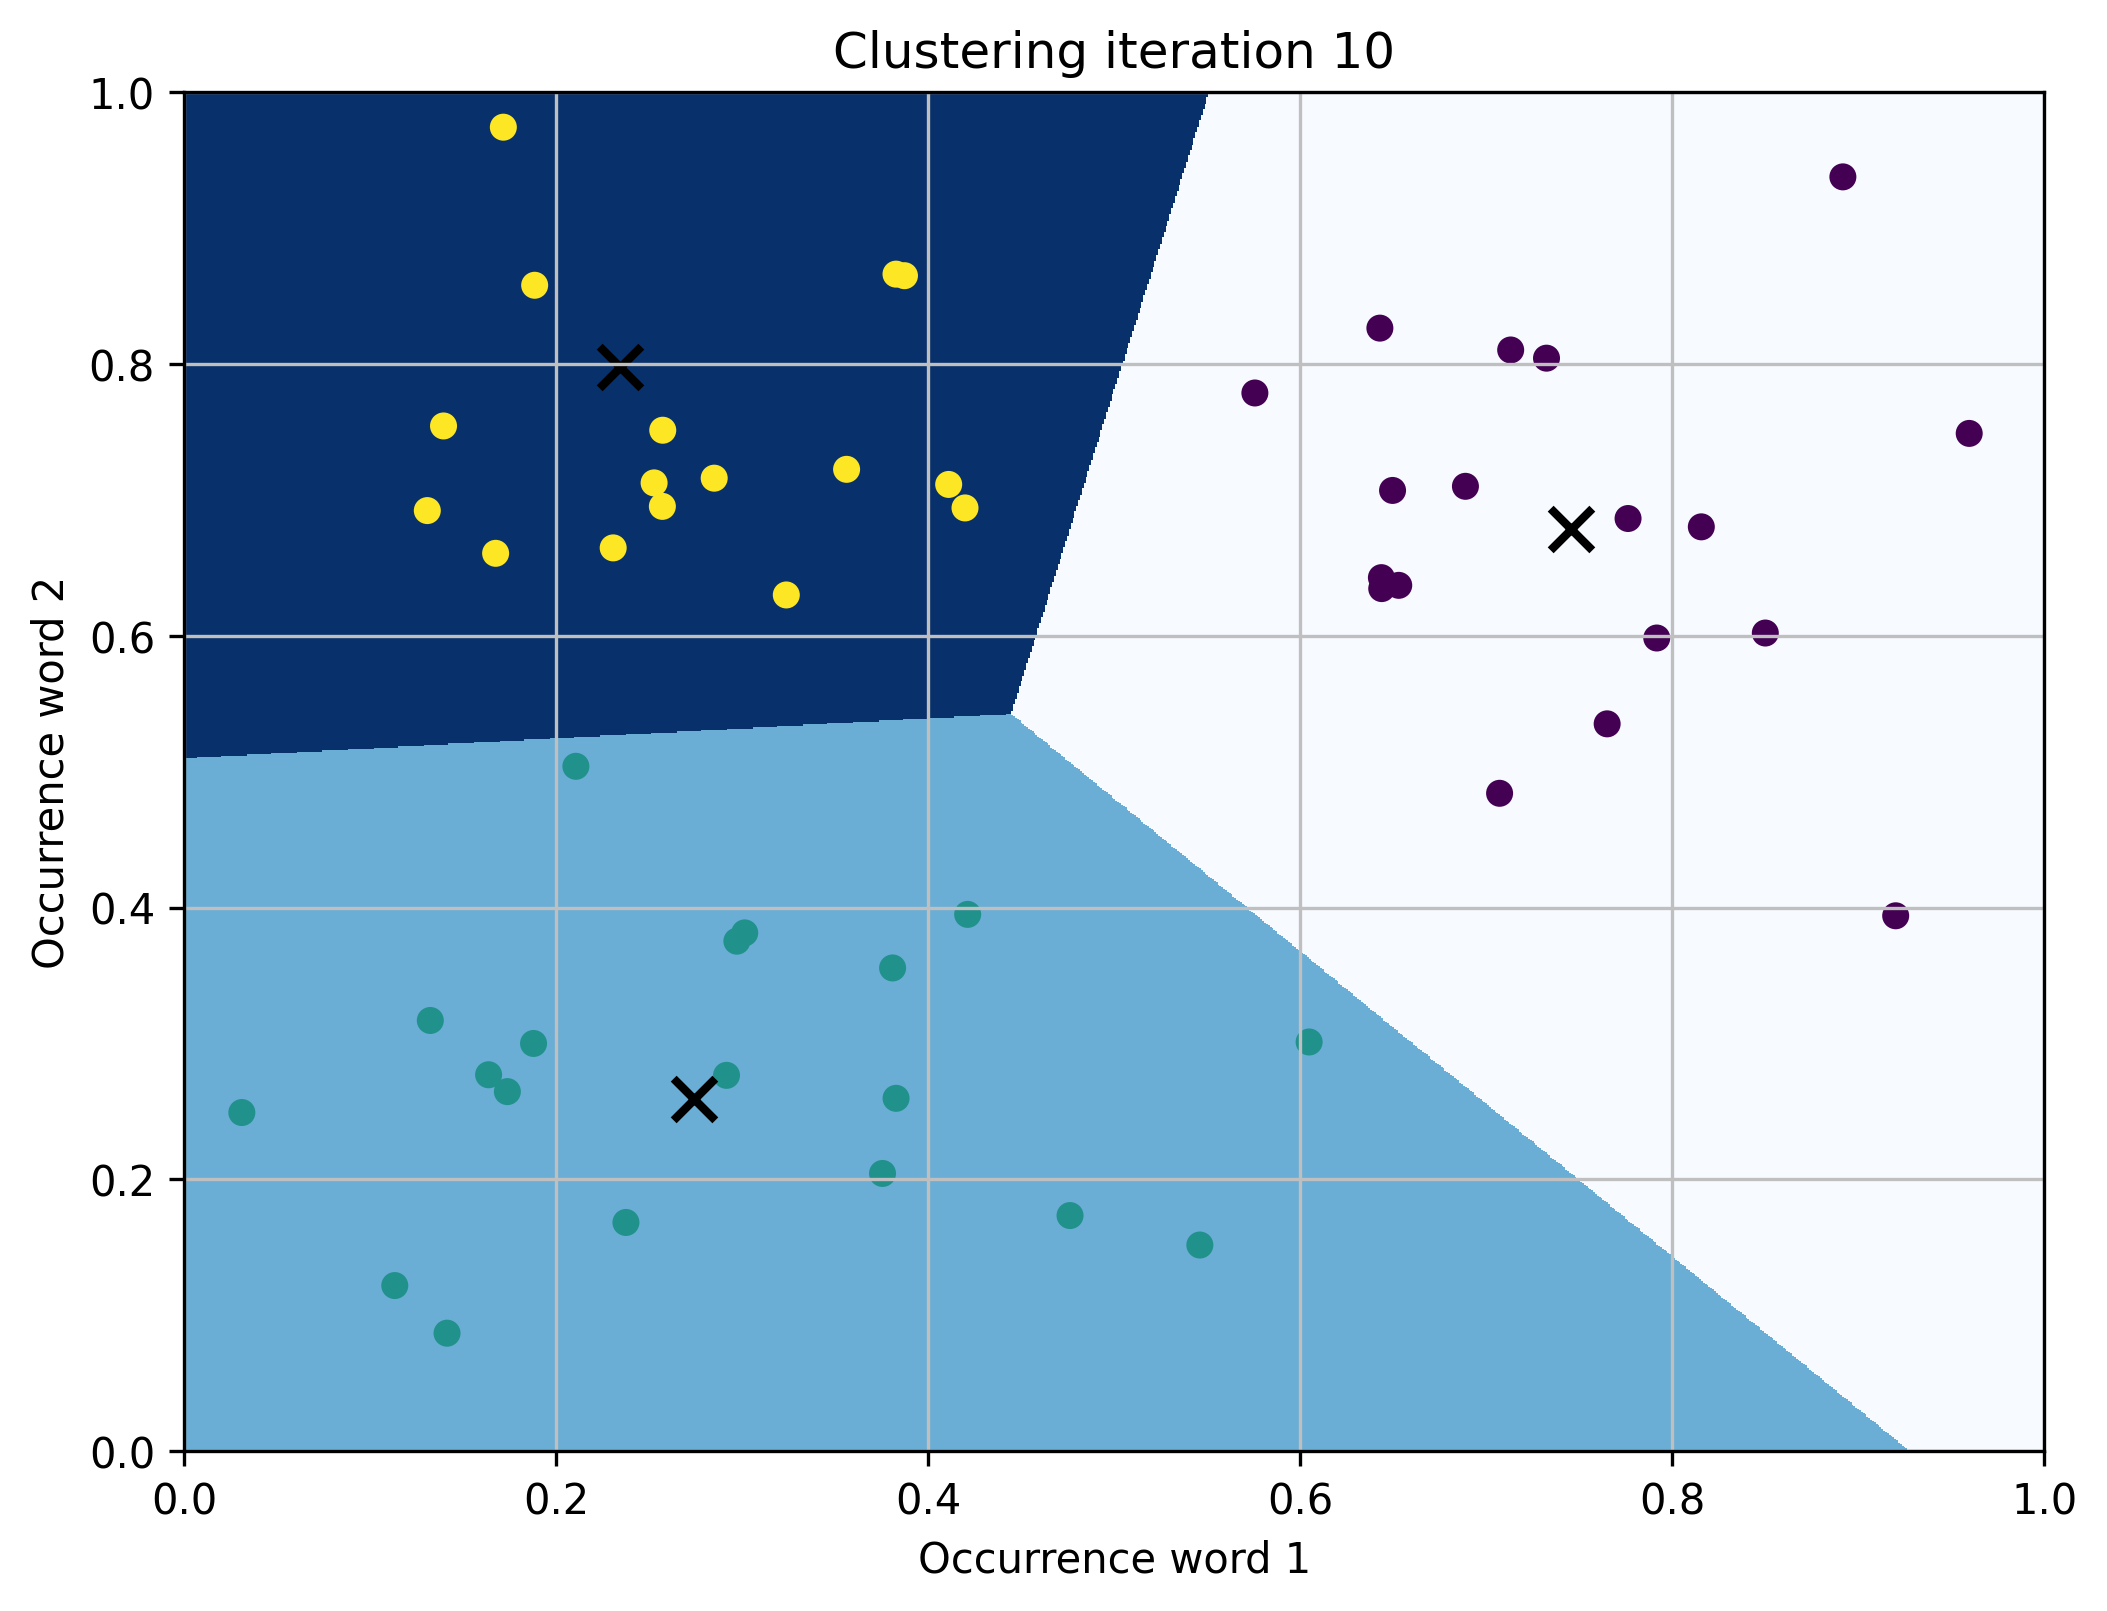

In [67]:
# Max 10 iterations 
km = KMeans(init='random', n_clusters=num_clusters, verbose=1, n_init=1, max_iter=10, random_state=seed)
km.fit(np.array(list(zip(x, y))))

Z = km.predict(np.c_[mx.ravel(), my.ravel()]).reshape(mx.shape)

plot_clustering(x, y, "Clustering iteration 10", km=km)
plt.imshow(Z, interpolation='nearest', extent=(mx.min(), mx.max(), my.min(), my.max()), cmap=plt.cm.Blues, aspect='auto', origin='lower')

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], marker='x', linewidth=2, s=100, color='black')

### Getting test data to evaluate our ideas

In [68]:
import sklearn.datasets

In [69]:
all_data = sklearn.datasets.fetch_20newsgroups(subset='all') 

In [70]:
print(len(all_data.filenames))

18846


In [71]:
print(all_data.target_names)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [72]:
train_data = sklearn.datasets.fetch_20newsgroups(subset="train")

In [73]:
print(len(train_data.filenames))

11314


In [74]:
test_data = sklearn.datasets.fetch_20newsgroups(subset='test')

In [75]:
print(len(test_data.filenames))

7532


In [76]:
# Restricting to only some newsgroups so that the overall experimentation cycle is shorter
groups = ['comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'sci.space']

In [77]:
train_data = sklearn.datasets.fetch_20newsgroups(subset='train', categories=groups)

In [78]:
print(len(train_data.filenames))

3529


In [79]:
test_data = sklearn.datasets.fetch_20newsgroups(subset='test', categories=groups)

In [80]:
print(len(test_data.filenames))

2349


## Clustering posts

In [81]:
vectorizer = StemmedTfidfVectorizer(min_df=10, max_df=0.5, stop_words='english', decode_error='ignore')

In [82]:
vectorized = vectorizer.fit_transform(train_data.data)

In [83]:
num_samples, num_features = vectorized.shape
print("#samples: %d, #features: %d" % (num_samples, num_features))

#samples: 3529, #features: 4712


In [84]:
num_clusters = 50
km = KMeans(n_clusters=num_clusters, n_init=1, verbose=1, random_state=3)
km.fit(vectorized)

Initialization complete
Iteration 0, inertia 5686.052543663697
Iteration 1, inertia 3164.887514012358
Iteration 2, inertia 3132.2077111951503
Iteration 3, inertia 3111.7125758781317
Iteration 4, inertia 3098.5837736478607
Iteration 5, inertia 3092.1905280374463
Iteration 6, inertia 3087.27708924431
Iteration 7, inertia 3084.100477377267
Iteration 8, inertia 3082.799767750698
Iteration 9, inertia 3082.234382617414
Iteration 10, inertia 3081.948798416197
Iteration 11, inertia 3081.8433339645703
Iteration 12, inertia 3081.790665037127
Iteration 13, inertia 3081.7522177638257
Iteration 14, inertia 3081.659718679882
Iteration 15, inertia 3081.6167914695066
Iteration 16, inertia 3081.5894842981666
Iteration 17, inertia 3081.5709703035764
Converged at iteration 17: strict convergence.


KMeans(n_clusters=50, n_init=1, random_state=3, verbose=1)

In [85]:
print("km.labels_=%s" % km.labels_)

km.labels_=[48 23 31 ...  6  2 22]


In [86]:
print("km.labels_.shape=%s" % km.labels_.shape)

km.labels_.shape=3529


### Solving our initial challenge

In [87]:
new_post = '''\
Disk drive problems. Hi, I have a problem with my hard disk.
After 1 year it is working only sporadically now.
I tried to format it, but now it doesn't boot any more.
Any ideas? Thanks.
'''

In [88]:
# Vectorizing this post before predicting its label
new_post_vec = vectorizer.transform([new_post])
new_post_label = km.predict(new_post_vec)[0]

In [89]:
# Fetching their indices in the original data set
similar_indices = (km.labels_==new_post_label).nonzero()[0]

In [90]:
similar = []
for i in similar_indices:
    dist = sp.linalg.norm((new_post_vec - vectorized[i]).toarray())
    similar.append((dist, train_data.data[i]))

In [91]:
similar = sorted(similar)
print("Count similar: %i" % len(similar))

Count similar: 56


In [92]:
# Presenting the most similar post (show_at_1), and two less similar but still related ones, all from the same cluster
show_at_1 = similar[0]
show_at_2 = similar[len(similar) // 10]
show_at_3 = similar[len(similar) // 2]

print("=== #1 ===")
print(show_at_1)
print()

print("=== #2 ===")
print(show_at_2)
print()

print("=== #3 ===")
print(show_at_3)

=== #1 ===
(1.0378441731334074, "From: Thomas Dachsel <GERTHD@mvs.sas.com>\nSubject: BOOT PROBLEM with IDE controller\nNntp-Posting-Host: sdcmvs.mvs.sas.com\nOrganization: SAS Institute Inc.\nLines: 25\n\nHi,\nI've got a Multi I/O card (IDE controller + serial/parallel\ninterface) and two floppy drives (5 1/4, 3 1/2) and a\nQuantum ProDrive 80AT connected to it.\nI was able to format the hard disk, but I could not boot from\nit. I can boot from drive A: (which disk drive does not matter)\nbut if I remove the disk from drive A and press the reset switch,\nthe LED of drive A: continues to glow, and the hard disk is\nnot accessed at all.\nI guess this must be a problem of either the Multi I/o card\nor floppy disk drive settings (jumper configuration?)\nDoes someone have any hint what could be the reason for it.\nPlease reply by email to GERTHD@MVS.SAS.COM\nThanks,\nThomas\n+-------------------------------------------------------------------+\n| Thomas Dachsel                              

### Another look at noise

In [93]:
post_group = zip(train_data.data, train_data.target)

In [94]:
all = [(len(post[0]), post[0], train_data.target_names[post[1]]) for post in post_group]

In [95]:
graphics = sorted([post for post in all if post[2] == 'comp.graphics'])
print(graphics[5])

(245, 'From: SITUNAYA@IBM3090.BHAM.AC.UK\nSubject: test....(sorry)\nOrganization: The University of Birmingham, United Kingdom\nLines: 1\nNNTP-Posting-Host: ibm3090.bham.ac.uk\n\n==============================================================================\n', 'comp.graphics')


For this post, there is no real indication that it belongs to comp.graphics considering only the wording that is left after the preprocessing step.

In [96]:
noise_post = graphics[5][1]

In [97]:
analyzer = vectorizer.build_analyzer()
print(list(analyzer(noise_post)))

['situnaya', 'ibm3090', 'bham', 'ac', 'uk', 'subject', 'test', 'sorri', 'organ', 'univers', 'birmingham', 'unit', 'kingdom', 'line', 'nntp', 'post', 'host', 'ibm3090', 'bham', 'ac', 'uk']


This is only after tokenization, lowercasing, and stop word removal. If we also subtract those words that will be later filtered out via min_df and max_df, which will be done later in fit_transform, it gets even worse.

In [98]:
useful = set(analyzer(noise_post)).intersection(vectorizer.get_feature_names())
print(sorted(useful))

['ac', 'birmingham', 'host', 'kingdom', 'nntp', 'sorri', 'test', 'uk', 'unit', 'univers']


In [99]:
for term in sorted(useful):
    print('IDF(%-10s) = %.2f' % (term, vectorizer._tfidf.idf_[vectorizer.vocabulary_[term]]))

IDF(ac        ) = 3.51
IDF(birmingham) = 6.77
IDF(host      ) = 1.74
IDF(kingdom   ) = 6.68
IDF(nntp      ) = 1.77
IDF(sorri     ) = 4.14
IDF(test      ) = 3.83
IDF(uk        ) = 3.70
IDF(unit      ) = 4.42
IDF(univers   ) = 1.91


So, the terms with the highest discriminative power, birmingham and kingdom, clearly are not that computer graphics related, the same is the case with the terms with lower IDF scores. Understandably, posts from different newsgroups will be clustered together.